<a href="https://colab.research.google.com/github/AnishBehera05/Predictive_analysis_using_ML/blob/main/Predicting_Apple_Stock_Prices_with_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Mean Squared Error: 4.878443852617151


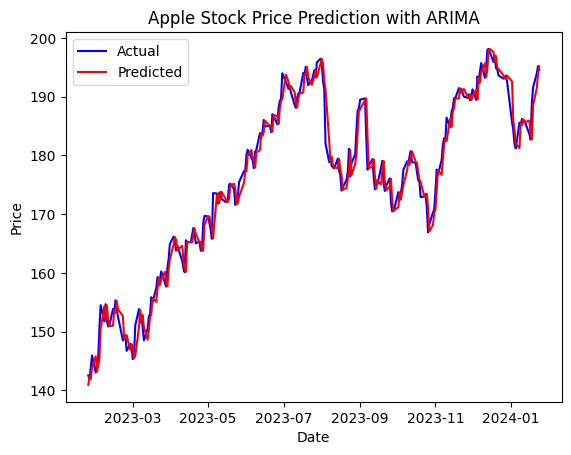

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# ARIMA model
model = ARIMA(train['Close'], order=(1, 1, 0))
arima_model = model.fit()

# Predictions
history = [x for x in train['Close']]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(1, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['Close'].iloc[t]
    history.append(obs)

# Evaluate ARIMA model
error = mean_squared_error(test['Close'], predictions)
print('ARIMA Mean Squared Error:', error)

# Visualize predictions
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.title('Apple Stock Price Prediction with ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 12054.054930140606
Iteration:      2,   Func. Count:     14,   Neg. LLF: 118346.71547510746
Iteration:      3,   Func. Count:     21,   Neg. LLF: 2197.9619655536035
Iteration:      4,   Func. Count:     27,   Neg. LLF: 2194.7453508103945
Iteration:      5,   Func. Count:     33,   Neg. LLF: 2189.645114494747
Iteration:      6,   Func. Count:     39,   Neg. LLF: 2182.4771278287653
Iteration:      7,   Func. Count:     44,   Neg. LLF: 2182.5145298315906
Iteration:      8,   Func. Count:     50,   Neg. LLF: 2182.463152808349
Iteration:      9,   Func. Count:     56,   Neg. LLF: 2182.459327961971
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2182.4593252001905
Iteration:     11,   Func. Count:     65,   Neg. LLF: 2182.459322719862
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2182.4593252001905
            Iterations: 11
            Function evaluations: 65
            Gradient evaluat

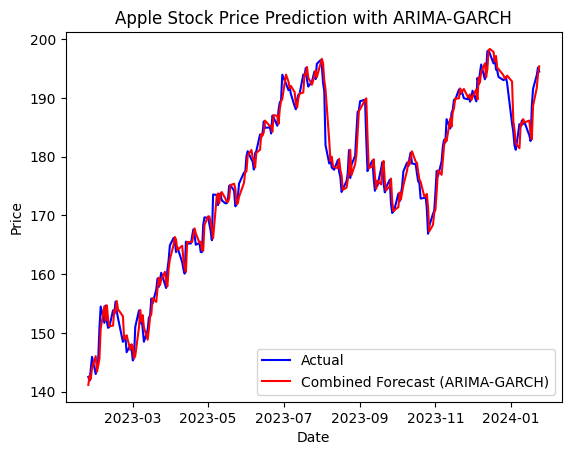

In [28]:
!pip install arch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit an ARIMA model
model = ARIMA(train['Close'], order=(1, 1, 0))
arima_model = model.fit()

# Extract residuals
residuals = arima_model.resid

# Fit a GARCH model to the residuals
garch_model = arch_model(residuals, vol='GARCH', p=1, q=1)
garch_model_fit = garch_model.fit()

# Initialize predictions list
predictions = []

# Prediction loop
history = list(train['Close'])
for t in range(len(test)):
    # Fit ARIMA model
    arima_model = ARIMA(history, order=(1, 1, 0))
    arima_model_fit = arima_model.fit()

    # Extract residuals
    residuals = arima_model_fit.resid

     # Fit GARCH model to the residuals
    garch_model = arch_model(residuals, vol='GARCH', p=1, q=1)
    garch_model_fit = garch_model.fit()

    # Forecast using ARIMA-GARCH model
    arima_forecast = arima_model_fit.forecast(steps=1)[0]
    garch_forecast = garch_model_fit.forecast(horizon=1).mean.iloc[-1].values[0]
    combined_forecast = arima_forecast + garch_forecast

    # Append prediction to predictions list
    predictions.append(combined_forecast)

    # Update history for next iteration
    history.append(test['Close'].iloc[t])

# Evaluate combined model
error = mean_squared_error(test['Close'], predictions)
print('Combined ARIMA-GARCH Mean Squared Error:', error)

# Visualize combined predictions
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Combined Forecast (ARIMA-GARCH)')
plt.title('Apple Stock Price Prediction with ARIMA-GARCH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [30]:
# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [31]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [32]:
# Fit an ARIMA model
model = ARIMA(train['Close'], order=(1, 1, 0))
arima_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [33]:
# Extract residuals
residuals = arima_model.resid

In [34]:
# Fit an ARCH model to the residuals
arch_model_fit = arch_model(residuals, vol='ARCH', p=1).fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4178.230526832091
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2386.9453605779477
Iteration:      3,   Func. Count:     18,   Neg. LLF: 2353.006638534687
Iteration:      4,   Func. Count:     24,   Neg. LLF: 2315.7632422585903
Iteration:      5,   Func. Count:     28,   Neg. LLF: 2315.76324104962
Iteration:      6,   Func. Count:     31,   Neg. LLF: 2315.763241049619
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2315.76324104962
            Iterations: 6
            Function evaluations: 31
            Gradient evaluations: 6


In [35]:
# Initialize predictions list
predictions = []

In [36]:
# Prediction loop
history = list(train['Close'])
for t in range(len(test)):
    # Fit ARIMA model
    arima_model = ARIMA(history, order=(1, 1, 0))
    arima_model_fit = arima_model.fit()

    # Extract residuals
    residuals = arima_model_fit.resid

    # Fit ARCH model to the residuals
    arch_model_fit = arch_model(residuals, vol='ARCH', p=1).fit()

    # Forecast using ARIMA-ARCH model
    arima_forecast = arima_model_fit.forecast(steps=1)[0]
    arch_forecast = arch_model_fit.forecast(horizon=1).mean.iloc[-1].values[0]
    combined_forecast = arima_forecast + arch_forecast

    # Append prediction to predictions list
    predictions.append(combined_forecast)

    # Update history for next iteration
    history.append(test['Close'].iloc[t])

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4178.230526832091
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2386.9453605779477
Iteration:      3,   Func. Count:     18,   Neg. LLF: 2353.006638534687
Iteration:      4,   Func. Count:     24,   Neg. LLF: 2315.7632422585903
Iteration:      5,   Func. Count:     28,   Neg. LLF: 2315.76324104962
Iteration:      6,   Func. Count:     31,   Neg. LLF: 2315.763241049619
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2315.76324104962
            Iterations: 6
            Function evaluations: 31
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4179.260064578635
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2389.7631920376443
Iteration:      3,   Func. Count:     18,   Neg. LLF: 2483.0921655385723
Iteration:      4,   Func. Count:     24,   Neg. LLF: 2317.8873852086604
Iteration:      5,   Func. Count:     28,   Neg. LLF: 2317.88738397158

In [37]:
# Evaluate combined model
error = mean_squared_error(test['Close'], predictions)
print('Combined ARIMA-ARCH Mean Squared Error:', error)

Combined ARIMA-ARCH Mean Squared Error: 4.835006865006943


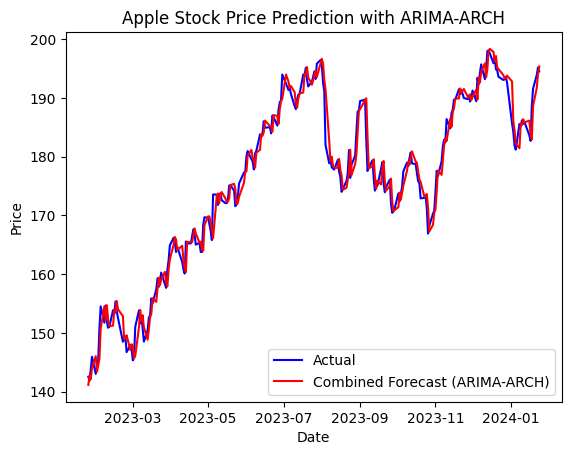

In [38]:
# Visualize combined predictions
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Combined Forecast (ARIMA-ARCH)')
plt.title('Apple Stock Price Prediction with ARIMA-ARCH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 68114744228.71037
Iteration:      2,   Func. Count:     15,   Neg. LLF: 45908.43496483216
Iteration:      3,   Func. Count:     23,   Neg. LLF: 632920314991.5338
Iteration:      4,   Func. Count:     32,   Neg. LLF: 2796.3486950820666
Iteration:      5,   Func. Count:     40,   Neg. LLF: 2159.525639687583
Iteration:      6,   Func. Count:     46,   Neg. LLF: 2157.917855592353
Iteration:      7,   Func. Count:     51,   Neg. LLF: 2157.9116647538403
Iteration:      8,   Func. Count:     56,   Neg. LLF: 2157.9113646109004
Iteration:      9,   Func. Count:     61,   Neg. LLF: 2157.911132936527
Iteration:     10,   Func. Count:     66,   Neg. LLF: 2157.9112479925634
Iteration:     11,   Func. Count:     72,   Neg. LLF: 2157.9112412409577
Iteration:     12,   Func. Count:     78,   Neg. LLF: 2157.9112403919084
Iteration:     13,   Func. Count:     84,   Neg. LLF: 2157.911240635041
Iteration:     14,   Func. Count:     90,   Neg. LLF: 2157

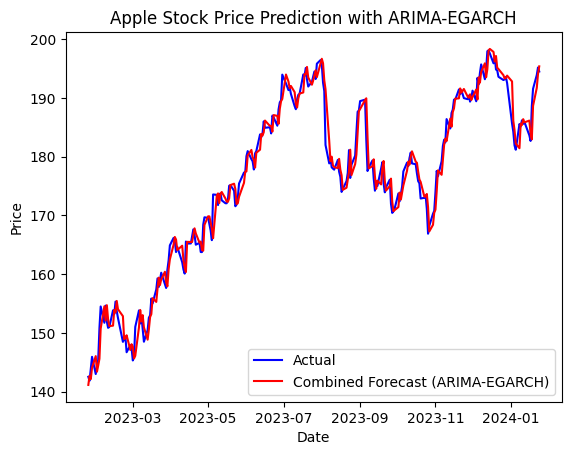

In [39]:
!pip install arch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit an ARIMA model
model = ARIMA(train['Close'], order=(1, 1, 0))
arima_model = model.fit()

# Extract residuals
residuals = arima_model.resid

# Initialize predictions list
predictions = []

# Prediction loop
history = list(train['Close'])
for t in range(len(test)):
    # Fit ARIMA model
    arima_model = ARIMA(history, order=(1, 1, 0))
    arima_model_fit = arima_model.fit()

    # Extract residuals
    residuals = arima_model_fit.resid

    # Fit EGARCH model to the residuals
    egarch_model = arch_model(residuals, vol='EGARCH', p=1, q=1)
    egarch_model_fit = egarch_model.fit()

    # Forecast using ARIMA-EGARCH model
    arima_forecast = arima_model_fit.forecast(steps=1)[0]
    egarch_forecast = egarch_model_fit.forecast(horizon=1).mean.iloc[-1].values[0]
    combined_forecast = arima_forecast + egarch_forecast

    # Append prediction to predictions list
    predictions.append(combined_forecast)

    # Update history for next iteration
    history.append(test['Close'].iloc[t])

# Evaluate combined model
error = mean_squared_error(test['Close'], predictions)
print('Combined ARIMA-EGARCH Mean Squared Error:', error)

# Visualize combined predictions
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Combined Forecast (ARIMA-EGARCH)')
plt.title('Apple Stock Price Prediction with ARIMA-EGARCH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Iteration:      1,   Func. Count:      7,   Neg. LLF: 5381.782855576785
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4688.601211780809
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4901.97052521204
Iteration:      4,   Func. Count:     35,   Neg. LLF: 4114.404190352756
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2659.8017628510497
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2235.56721977446
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2235.392798366117
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2235.2758503762543
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2235.270007695527
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2235.26971055205
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2235.269101146231
Iteration:     12,   Func. Count:     86,   Neg. LLF: 2235.269087755746
Iteration:     13,   Func. Count:     92,   Neg. LLF: 2238.190880678115
Optimization terminated successfully    (Exit mode 0)
           

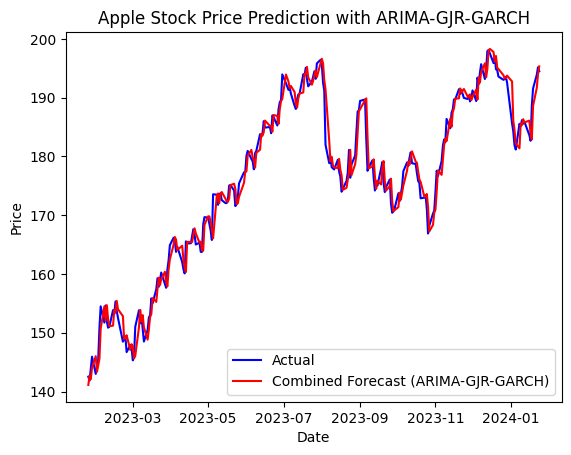

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit an ARIMA model
model = ARIMA(train['Close'], order=(1, 1, 0))
arima_model = model.fit()

# Extract residuals
residuals = arima_model.resid

# Initialize predictions list
predictions = []

# Prediction loop
history = list(train['Close'])
for t in range(len(test)):
    # Fit ARIMA model
    arima_model = ARIMA(history, order=(1, 1, 0))
    arima_model_fit = arima_model.fit()

    # Extract residuals
    residuals = arima_model_fit.resid

    # Fit GJR-GARCH model to the residuals
    gjr_garch_model = arch_model(residuals, vol='GARCH', p=1, o=1, q=1, power=1)
    gjr_garch_model_fit = gjr_garch_model.fit()

    # Forecast using ARIMA-GJR-GARCH model
    arima_forecast = arima_model_fit.forecast(steps=1)[0]
    gjr_garch_forecast = gjr_garch_model_fit.forecast(horizon=1).mean.iloc[-1].values[0]
    combined_forecast = arima_forecast + gjr_garch_forecast

    # Append prediction to predictions list
    predictions.append(combined_forecast)

    # Update history for next iteration
    history.append(test['Close'].iloc[t])

# Evaluate combined model
error = mean_squared_error(test['Close'], predictions)
print('Combined ARIMA-GJR-GARCH Mean Squared Error:', error)

# Visualize combined predictions
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Combined Forecast (ARIMA-GJR-GARCH)')
plt.title('Apple Stock Price Prediction with ARIMA-GJR-GARCH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Iteration:      1,   Func. Count:      7,   Neg. LLF: 123339816983.55621
Iteration:      2,   Func. Count:     16,   Neg. LLF: 92133.6796033667
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2300.4886030502344
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2287.359431681311
Iteration:      5,   Func. Count:     37,   Neg. LLF: 2195.998473046729
Iteration:      6,   Func. Count:     44,   Neg. LLF: 2221.270453627278
Iteration:      7,   Func. Count:     51,   Neg. LLF: 2179.4683831565612
Iteration:      8,   Func. Count:     57,   Neg. LLF: 2178.727424549801
Iteration:      9,   Func. Count:     63,   Neg. LLF: 2178.581092157168
Iteration:     10,   Func. Count:     69,   Neg. LLF: 2178.5647814819886
Iteration:     11,   Func. Count:     75,   Neg. LLF: 2178.5604176449056
Iteration:     12,   Func. Count:     81,   Neg. LLF: 2178.5603706411716
Iteration:     13,   Func. Count:     87,   Neg. LLF: 2178.560368561328
Iteration:     14,   Func. Count:     93,   Neg. LLF: 2178.

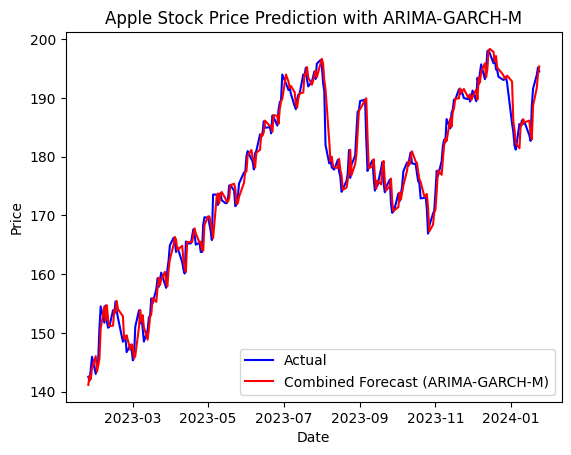

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit an ARIMA model
model = ARIMA(train['Close'], order=(1, 1, 0))
arima_model = model.fit()

# Extract residuals
residuals = arima_model.resid

# Initialize predictions list
predictions = []

# Prediction loop
history = list(train['Close'])
for t in range(len(test)):
    # Fit ARIMA model
    arima_model = ARIMA(history, order=(1, 1, 0))
    arima_model_fit = arima_model.fit()

    # Extract residuals
    residuals = arima_model_fit.resid

    # Fit GARCH-M model to the residuals
    garch_mean_model = arch_model(residuals, vol='GARCH', p=1, o=1, q=1)
    garch_mean_model_fit = garch_mean_model.fit()

    # Forecast using ARIMA-GARCH-M model
    arima_forecast = arima_model_fit.forecast(steps=1)[0]
    garch_mean_forecast = garch_mean_model_fit.forecast(horizon=1).mean.iloc[-1].values[0]
    combined_forecast = arima_forecast + garch_mean_forecast

    # Append prediction to predictions list
    predictions.append(combined_forecast)

    # Update history for next iteration
    history.append(test['Close'].iloc[t])

# Evaluate combined model
error = mean_squared_error(test['Close'], predictions)
print('Combined ARIMA-GARCH-M Mean Squared Error:', error)

# Visualize combined predictions
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Combined Forecast (ARIMA-GARCH-M)')
plt.title('Apple Stock Price Prediction with ARIMA-GARCH-M')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
